In [1]:
%run Solution.ipynb
%run ArrheniusDiagram.ipynb

<Figure size 640x480 with 1 Axes>

In [2]:
def calculate_delta_r1(T):
    return 2 * G0('Al', T) + 2 * G0('HCl', T) - 2 * G0('AlCl', T) - G0('H2', T)

def calculate_delta_r2(T):
    return G0('Al', T) + 2 * G0('HCl', T) - G0('AlCl2', T) - G0('H2', T)

def calculate_delta_r3(T):
    return 2 * G0('Al', T) + 6 * G0('HCl', T) - 2 * G0('AlCl3', T) - 3 * G0('H2', T)

In [3]:
Pa = 100000

def K1(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r1(T) / (R * T)) / Pa

def K2(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r2(T) / (R * T))

def K3(T, R = 8.314):
    return math.exp(-1 * calculate_delta_r3(T) / (R * T)) / Pa



K1, K2, K3 - температурно-зависимые константы равновесия реакций, полученные для реакций R1-R3 при помощи применения правила Гиббса для данных реакций и законов действующих масс.

In [4]:
T = 623.15
print(K1(T))
print(K2(T))
print(K3(T))

7.497131271125371e-07
7.221267004644182e-08
4.062199476332757e-49


In [5]:
print(D('AlCl', T))
print(D('AlCl2', T))
print(D('AlCl3', T))
print(D('HCl', T))
print(D('H2', T))

0.000191129931554728
0.00014747988098603198
0.00015245155020045148
0.0002736394738546893
0.0008762807050502889


In [6]:
PG = {
   'AlCl':0,
   'AlCl2':0,
   'AlCl3':0,
   'H2':0,
   'HCl':10000,
   'N2':90000
}

def P_AlCl2(T, p):
    return K1(T)*(p**2) / K2(T)
    
def P_AlCl3(T, p):
    return (p**3) * ((K1(T) ** 3) / K3(T)) ** 0.5


Matrix([[-7.49713127112537e-7*AlCl**2*(797375999396014.0*AlCl**2 + 3.4946302917533*AlCl + 0.109057480356) - 1.49942625422507e-6*AlCl*(265791999798671.0*AlCl**3 + 1.74731514587665*AlCl**2 + 0.109057480356*AlCl) + 2.89782934131119e+30*(-6*AlCl**2 - 2.62959780158949e-14*AlCl - 8.20622745896097e-16)*(-AlCl**3 - 6.57399450397372e-15*AlCl**2 - 4.10311372948049e-16*AlCl + 5.8744011101134e-12)]])

2
{'AlCl': 0.000180435171757920, 'AlCl2': 3.38005764249853e-7, 'AlCl3': 5983.09146315765}


In [8]:
def get_res(T, ro=2697):
    AlCl= sy.symbols('AlCl')
    AlCl2 = K1(T)*(AlCl**2) / K2(T)
    AlCl3 = (AlCl**3) * ((K1(T) ** 3) / K3(T)) ** 0.5
    Theta = (D('AlCl', T) * (PG['AlCl'] - AlCl) + 2 * D('AlCl2', T) * (PG['AlCl2'] - AlCl2) + \
            3 * D('AlCl3', T) * (PG['AlCl3'] - AlCl3))
    X = sy.Matrix([
        (Theta / D('HCl', T) + PG['HCl'])**2 - K2(T) * AlCl2 * (PG['H2'] - Theta/(2*D('H2', T)))
    ])
    Y = [AlCl]
    ans = newton_method(X * (10 ** 30), Y, [1])
    P = {'AlCl': ans[0], 'AlCl2': P_AlCl2(T, ans[0]), 'AlCl3': P_AlCl3(T, ans[0])}
    G_AlCl = G('AlCl', T, PG, P)
    G_AlCl2 = G('AlCl2', T, PG, P)
    G_AlCl3 = G('AlCl3', T, PG, P)
    V = (G_AlCl + G_AlCl2 + G_AlCl3) * bank_td['Al']['mu'] * 1e9 / ro
    return [G_AlCl, G_AlCl2, G_AlCl3, V]

Для более произодительного и быстрого решения данной системы нелинейных уравнений мы упростили изначально заданную систему с 5 переменными до системы с 3мя переменными, выразив $P_{HCl}^{e}$ и $P_{H_2}^{e}$ через $P_{AlCl}^{e}$, $P_{AlCl_2}^{e}$ и $P_{AlCl_3}^{e}$. В результате получилась такая система:


$
\left\{\begin{matrix}
 & K_1 * (P_{AlCl}^{e})^{2} - K_2 * P_{AlCl_2} = 0 & \\ 
 & (\frac{\Theta}{D_{HCl}} + P_{HCl}^g)^2 = K_2P_{AlCl_2}^e(P_{H_2}^g - \frac{\Theta}{2D_{H_2}}) & \\ 
 & (K_2 * P_{AlCl_2}^e)^3 - K_3 * (P_{AlCl_3}^e)^2 = 0 & 
\end{matrix}\right.$


где $\Theta = D_{AlCl} * (P_{AlCl}^g - P_{AlCl}^{e}) + 2 * D_{AlCl_2} * (P_{AlCl_2}^g - P_{AlCl_2}^{e}) + 3 * D_{AlCl_3} * (P_{AlCl_3}^g - P_{AlCl_3}^{e})$

Затем в ходе вычислений выяснилось, что и система из 3х уравнений не всегда решается быстро при одинаковых начальных приближениях, но разных значениях температуры. Поэтому было решено свести систему к одному уравнению.
Оставлена была переменная $P_{AlCl}^e$. Остальные переменные выражаются через нее так:

$P_{AlCl_2}=\frac{K_1(P_{AlCl}^e)^2}{K_2}$

$P_{AlCl_3}=(P_{AlCl}^e)^3\sqrt{\frac{K_1^3}{K_3}}$

$\Theta = D_{AlCl} * (P_{AlCl}^g - P_{AlCl}^{e}) + 2 * D_{AlCl_2} * (P_{AlCl_2}^g - \frac{K_1(P_{AlCl}^e)^2}{K_2}) + 3 * D_{AlCl_3} * (P_{AlCl_3}^g - (P_{AlCl}^e)^3\sqrt{\frac{K_1^3}{K_3}})$

Система приняла такой вид: $(\frac{\Theta}{D_{HCl}} + P_{HCl}^g)^2 = K_2P_{AlCl_2}^e(P_{H_2}^g - \frac{\Theta}{2D_{H_2}})$

In [9]:
ts = 350
tf = 650
T = np.linspace(ts + 273.15, tf + 273.15)
G1_res = []
G2_res = []
G3_res = []
V_res = []
for t in T:
    curr_res = get_res(t)
    G1_res.append(curr_res[0])
    G2_res.append(curr_res[1])
    G3_res.append(curr_res[2])
    V_res.append(curr_res[3])


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


График зависимости G_AlCl от температуры


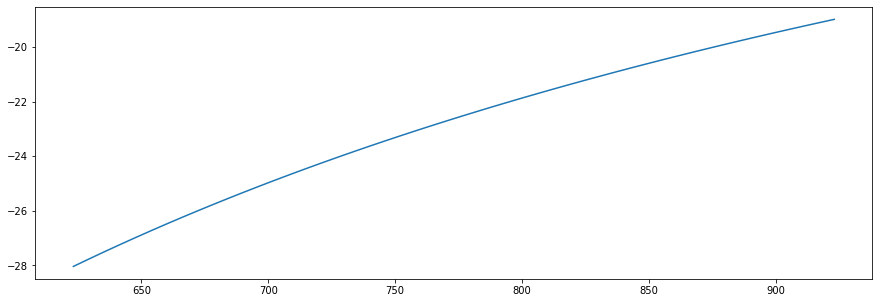

График зависимости G_AlCl2 от температуры


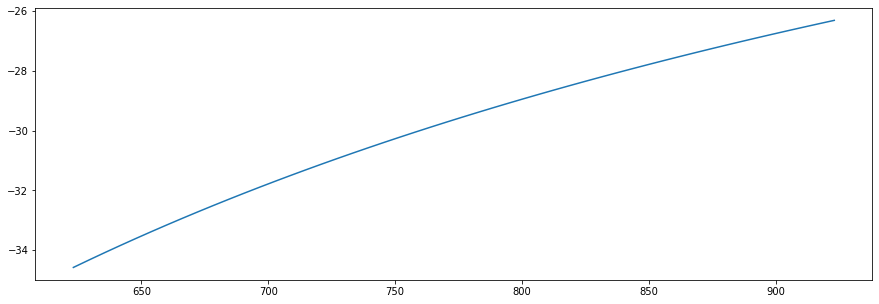

График зависимости G_AlCl3 от температуры


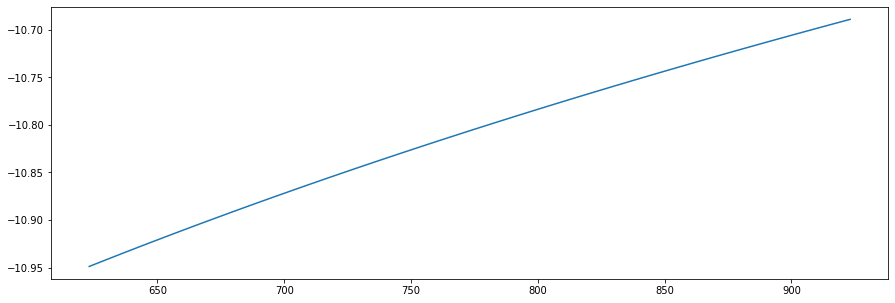

График зависимости V от температуры


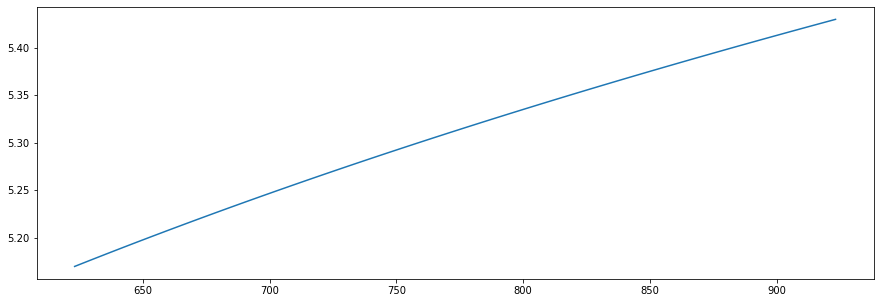

In [10]:
print("График зависимости G_AlCl от температуры")
print_graph_arr(T, G1_res)
print("График зависимости G_AlCl2 от температуры")
print_graph_arr(T, G2_res)
print("График зависимости G_AlCl3 от температуры")
print_graph_arr(T, G3_res)
print("График зависимости V от температуры")
print_graph_arr(T, V_res)